# The compare pipeline

The pipeline estimates cumulative savings given the optimized predictive model and post-retrofit data, while adding uncertainty intervals with user-provided confidence levels.

Uncertainty intervals are useful for evaluating the confidence one should have about a model's predictions, but in M&V we often need to quantify the uncertainty of cumulative sums of the energy savings.

For this purpose, `eensight` includes functionality for sampling from the distribution that is implied by the uncertainty intervals.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from eensight.utils.jupyter import load_catalog
from eensight.pipelines.compare.sampling import generate_samples

In [3]:
catalog = load_catalog('demo', partial_catalog=True)

Comparison makes sense only for `apply` data.

In [4]:
data = catalog.load('apply.model_input_data')

to_drop = data.filter(like="_outlier", axis=1).columns.to_list()
if len(to_drop) > 0:
    data = data.drop(to_drop, axis=1)

y_true = None
if "consumption" in data:
    y_true = data.pop("consumption")

2021-11-18 23:10:19,345 - kedro.io.data_catalog - INFO - Loading data from `apply.model_input_data` (CSVDataSet)...


In [5]:
mean_model = catalog.load('mean_model')
conformal_model = catalog.load('conformal_model')

2021-11-18 23:10:21,783 - kedro.io.data_catalog - INFO - Loading data from `mean_model` (PickleDataSet)...
2021-11-18 23:10:23,410 - numba.cuda.cudadrv.driver - INFO - init
2021-11-18 23:10:23,499 - kedro.io.data_catalog - INFO - Loading data from `conformal_model` (PickleDataSet)...


In [6]:
%%time

significance = np.linspace(0, 1, 20)[1:-1]

pred_mean = mean_model.predict(data)
pred_conf = conformal_model.predict(data, significance)

Wall time: 14.8 s


In [7]:
%%time
samples = generate_samples(200, prediction=pred_mean['consumption'], 
                                quantiles=pred_conf
)

Wall time: 10.2 s


In [8]:
def plot_samples(X, samples, size=2000, title=''):
    start = np.random.randint(0, high=len(X)-size)
    
    with plt.style.context('seaborn-whitegrid'):    
        fig = plt.figure(figsize=(12, 3.54), dpi=96)
        layout = (1, 1)
        ax = plt.subplot2grid(layout, (0, 0))
        
        samples.iloc[start:start+size].plot(ax=ax, alpha=0.005, color='#DDA0DD', legend=False)
            
        X.iloc[start:start+size].plot(
            ax=ax, alpha=0.8, rot=0)
        ax.set_title(title)


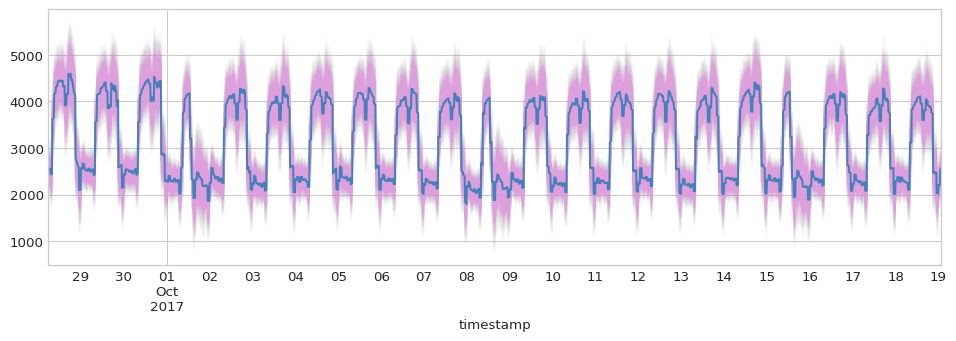

In [9]:
plot_samples(pred_mean['consumption'], samples)

The corresponding samples for the savings are calculated as:

In [10]:
savings = samples.sub(y_true, axis=0)

The fractional savings (the energy savings over `x` steps in the reporting period divided by the predicted baseline usage during that same period) are calculated as:

In [11]:
fract_savings = savings.apply(np.cumsum, axis=0).div(pred_mean['consumption'].cumsum(), axis=0)

The distribution of the fractional savings at the end of the data period is:

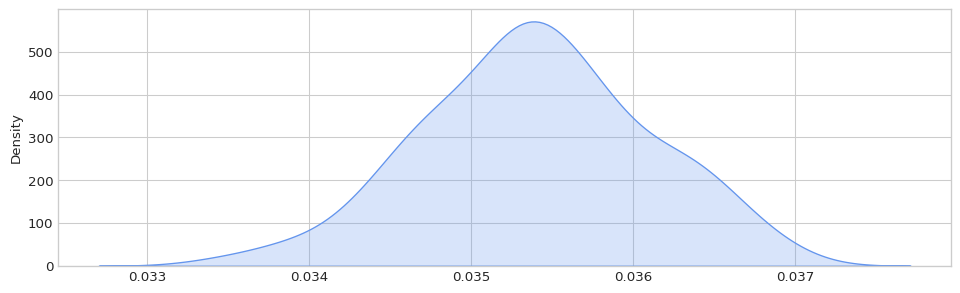

In [12]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    sns.kdeplot(fract_savings.iloc[-1], ax=ax, color="#6495ED", shade=True)
    ax.set_xlabel(None)

Obviously, the `apply` dataset does not include significant energy savings. 

-----------------------------------